In [10]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import os
#import xgboost as xgb
#import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
import eli5
from functools import reduce
import warnings
from sklearn.metrics import mean_squared_error
from scipy import stats
from math import sqrt
from lightgbm import plot_tree
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import STATUS_OK
from hyperopt.pyll.stochastic import sample
import time
import gc
warnings.filterwarnings('ignore')
#import shap

In [16]:
train = pd.read_csv('FE_train.csv')
test  = pd.read_csv('FE_test.csv')
gc.collect()

8906

In [6]:
def display_importances(feature_importance_df):
    cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

In [7]:
def Submission(Ids, preds):
    file_name = datetime.datetime.today().strftime('%m-%d-%H-%M')
    submission = pd.DataFrame({'building_id' : Ids, 'total_price' : preds})
    if not os.path.isdir('Submission'):
        os.makedirs('Submission')
    submission.to_csv('Submission/' + file_name + '.csv', index= False)

In [13]:
def lgb_model(split_num, train, test, features, stratified = False):
    if stratified:
        kf = StratifiedKFold(n_splits = split_num, random_state = 42, shuffle = True)
    else :
        kf = KFold(n_splits=split_num, shuffle=True,random_state=42)
    train['total_price_log'] = np.log1p(train['total_price'])
    feature_importance_df = pd.DataFrame()
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    
    param ={
        'n_estimators': 10000, 'max_depth' : 5, 'num_leaves' :30,         
        'objective': 'regression',   'metric':'rmse',   
        'learning_rate': 0.01,      'boosting': 'gbdt',     'min_data_in_leaf': 10,
        'feature_fraction': 0.9,    'bagging_freq':1,       'bagging_fraction': 0.9,     'importance_type': 'gain',
        'lambda_l1': 0.2,  'subsample': .8,   'colsample_bytree': .9
    }
    for fold_, (trn_idx, val_idx) in enumerate(kf.split(train[features].values,train['total_price_log'].values)):
        trn_data = lgb.Dataset(train.iloc[trn_idx][features], label= train['total_price_log'].iloc[trn_idx])
        val_data = lgb.Dataset(train.iloc[val_idx][features], label= train['total_price_log'].iloc[val_idx])
        
        
        clf = lgb.train(params= param, train_set= trn_data, valid_sets= [trn_data, val_data], verbose_eval=200, early_stopping_rounds= 1000)
        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration = clf.best_iteration)
        predictions += clf.predict(test[features], num_iteration = clf.best_iteration) / kf.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature']    = features
        fold_importance_df['importance'] = np.log1p(clf.feature_importance(importance_type='gain', iteration=clf.best_iteration))
        fold_importance_df['fold']       = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print('CV scrore : {}'.format(sqrt(mean_squared_error(train['total_price_log'], oof))))
    display_importances(feature_importance_df)
    return predictions


Training until validation scores don't improve for 1000 rounds.
[200]	training's rmse: 0.413259	valid_1's rmse: 0.412945
[400]	training's rmse: 0.290674	valid_1's rmse: 0.296265
[600]	training's rmse: 0.258716	valid_1's rmse: 0.267878
[800]	training's rmse: 0.243284	valid_1's rmse: 0.255029
[1000]	training's rmse: 0.232652	valid_1's rmse: 0.246551
[1200]	training's rmse: 0.224983	valid_1's rmse: 0.240721
[1400]	training's rmse: 0.218804	valid_1's rmse: 0.236311
[1600]	training's rmse: 0.213359	valid_1's rmse: 0.232642
[1800]	training's rmse: 0.208708	valid_1's rmse: 0.229682
[2000]	training's rmse: 0.204581	valid_1's rmse: 0.22716
[2200]	training's rmse: 0.200681	valid_1's rmse: 0.224832
[2400]	training's rmse: 0.197226	valid_1's rmse: 0.222901
[2600]	training's rmse: 0.19388	valid_1's rmse: 0.221065
[2800]	training's rmse: 0.190745	valid_1's rmse: 0.219451
[3000]	training's rmse: 0.18787	valid_1's rmse: 0.217992
[3200]	training's rmse: 0.185169	valid_1's rmse: 0.216666
[3400]	training

[7400]	training's rmse: 0.146127	valid_1's rmse: 0.210912
[7600]	training's rmse: 0.144789	valid_1's rmse: 0.210597
[7800]	training's rmse: 0.143417	valid_1's rmse: 0.210227
[8000]	training's rmse: 0.142121	valid_1's rmse: 0.209951
[8200]	training's rmse: 0.14083	valid_1's rmse: 0.20965
[8400]	training's rmse: 0.139573	valid_1's rmse: 0.209363
[8600]	training's rmse: 0.138339	valid_1's rmse: 0.209086
[8800]	training's rmse: 0.137093	valid_1's rmse: 0.208793
[9000]	training's rmse: 0.135852	valid_1's rmse: 0.208508
[9200]	training's rmse: 0.134739	valid_1's rmse: 0.20825
[9400]	training's rmse: 0.133535	valid_1's rmse: 0.208003
[9600]	training's rmse: 0.132425	valid_1's rmse: 0.207777
[9800]	training's rmse: 0.131382	valid_1's rmse: 0.207567
[10000]	training's rmse: 0.130278	valid_1's rmse: 0.207364
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.130278	valid_1's rmse: 0.207364
Training until validation scores don't improve for 1000 rounds.
[200]	training's rm

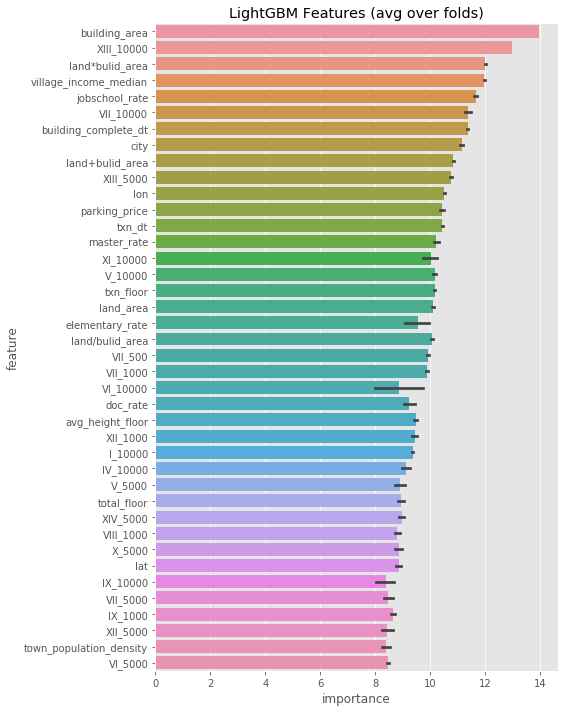

In [18]:
begin = time.time()
features = [i for i in train.columns if i not in ['building_id', 'total_price','total_price_log']] 
prediction = lgb_model(5, train, test, features, stratified = False)
prediction = np.expm1(prediction)
print((time.time() - begin) / 60)

In [20]:
Submission(test['building_id'], np.expm1(prediction))

In [22]:
prediction

array([10848311.41096416,  3880356.24270884,  9535897.71912022, ...,
         980239.56430158,  2992501.17899127,  3172202.46389105])

In [ ]:
#prediction = lgb_model(5, train, test, features, stratified = False)
#prediction = np.expm1(prediction)

In [9]:
train['total_price'].min()

226149.5239862996

In [11]:
train['total_price'].max()

5088279096.76905

In [18]:
np.log1p(np.log1p(5088279096.76905))

3.1506057856008445